**1) Hypothesis Generation:**




*   Product related:

1.   Lower weighted products may lead to more sales.(null hypothesis)
2.   More popular products lead to higher sales.(info unavailable)
3.   Products used on a daily basis like dairy products may lead to more sales.(null hypothesis)
4.   Expensive products will lead to higher sales; cigarettes form most of convenience stores' sales.(proven True)
5.   Item visibility will increase sales. (proven wrong, opposite)


*   Store related:
1.   Stores in more populated areas will achieve higher sales (Almost True)
2.   Newly established stores may lead to higher sales. (Null Hypothesis)
3.   Bigger sized outlets may lead to higher sales.(Null hypothesis, Alternate: Medium sized tend to accomplish highest sales)


**2) Loading packages and data**


In [544]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [545]:
sales= pd.read_csv("/content/Bigmart_Sales_Data/Train.csv")
sales_test = pd.read_csv("/content/Bigmart_Sales_Data/Test.csv")
sales = sales.rename(columns= {'Item_Outlet_Sales' : 'Sales'})
sales_test = sales_test.rename(columns= {'Item_Outlet_Sales' : 'Sales'})

**3) Data Structure and Content**

In [546]:
sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [547]:
sales.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [548]:
#checking how many null values in each column
sales.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Sales                           0
dtype: int64

In [549]:
missing_weight = sales.Item_Weight.isnull().sum()
total_weight = sales.Item_Weight.count()
print("missing Item_Weight percentage = {:.2f} %".format(missing_weight * 100 / total_weight))

missing_size = sales.Outlet_Size.isnull().sum()
total_size = total_weight
print("missing Outlet_Size percentage = {:.2f} %".format(missing_size * 100 / total_size))

missing Item_Weight percentage = 20.72 %
missing Outlet_Size percentage = 34.14 %


we see that we have a lot of missing data in the Item_Weight and Outlet_Size columns, we'll address them later when we get to the missing values section.

In [550]:
#splitting numerical and categorical columns and checking unique values
cat_cols = sales.select_dtypes(include=['object'])
num_cols = sales.columns.difference(cat_cols)
cat_cols.nunique()

Item_Identifier         1559
Item_Fat_Content           5
Item_Type                 16
Outlet_Identifier         10
Outlet_Size                3
Outlet_Location_Type       3
Outlet_Type                4
dtype: int64

We see here that Item_Identifier has too many unique variables! It would be best to drop that column, specially that it most likely does not have much of an effect on our target.

In [551]:
#drop Item_Identifier column
sales = sales.drop('Item_Identifier', axis=1)

Another point, why does Item_Fat_content have too many unique values? I remember it only containing Low Fat and Regular, let's check its unique values.

In [552]:
sales.Item_Fat_Content.unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

That's why! Now, we should rename the duplicate values.



In [553]:
sales.Item_Fat_Content.replace({'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'}, inplace=True)
sales.Item_Fat_Content.unique()

array(['Low Fat', 'Regular'], dtype=object)

How about Item_Type?

In [554]:
sales.Item_Type.unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

In [555]:
sales.Item_Type.replace({'Breads':'Baking Goods'}, inplace=True)
sales.Item_Type.unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Starchy Foods', 'Others', 'Seafood'], dtype=object)

**4) Exploratory Data Analysis**

<Axes: xlabel='Sales', ylabel='Outlet_Identifier'>

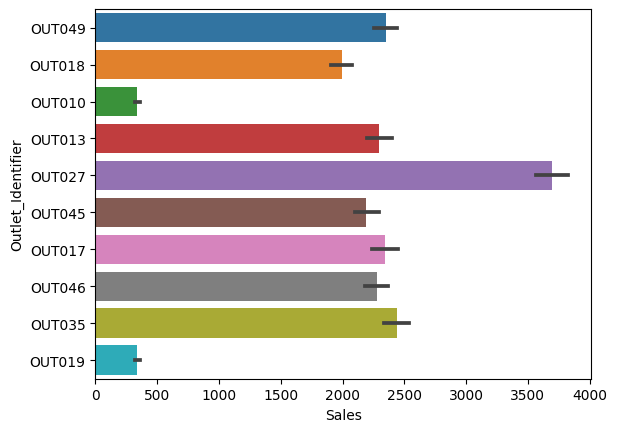

In [556]:
sns.barplot(x=sales.Sales, y=sales.Outlet_Identifier)

This shows that some outlets achieve significally higher sales than others!

<Axes: xlabel='Item_Weight', ylabel='Sales'>

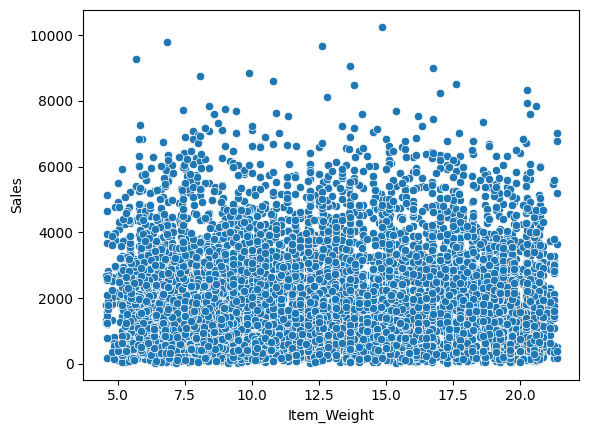

In [557]:
sns.scatterplot(x=sales.Item_Weight, y=sales.Sales)

Looks like our hypothesis that Lower item weight may lead to higher sales was proved wrong by the above scatter plot.

<Axes: xlabel='Item_MRP', ylabel='Sales'>

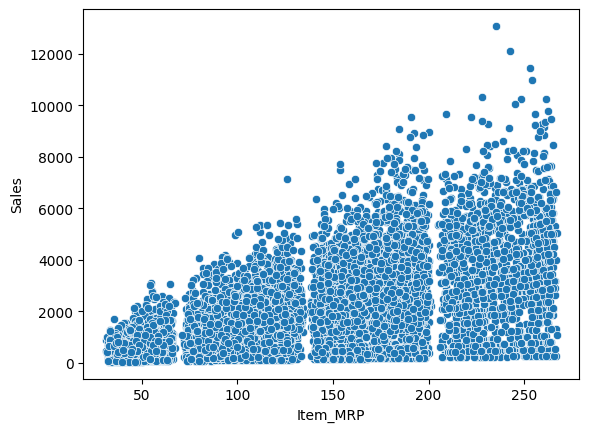

In [558]:
sns.scatterplot(x=sales.Item_MRP, y=sales.Sales)

Makes sense! Higher item price does lead to higher sales.

<Axes: xlabel='Sales', ylabel='Item_Type'>

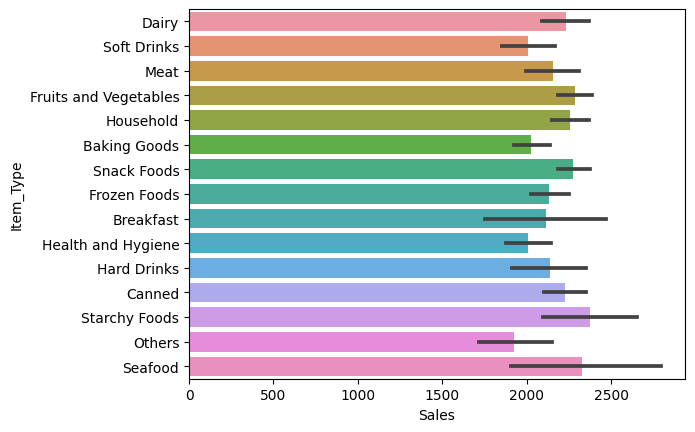

In [559]:
sns.barplot(x=sales.Sales, y=sales.Item_Type)

Another failed hypothesis, item type doesn't seem to have that much of effect on sales.

<Axes: xlabel='Item_Visibility', ylabel='Sales'>

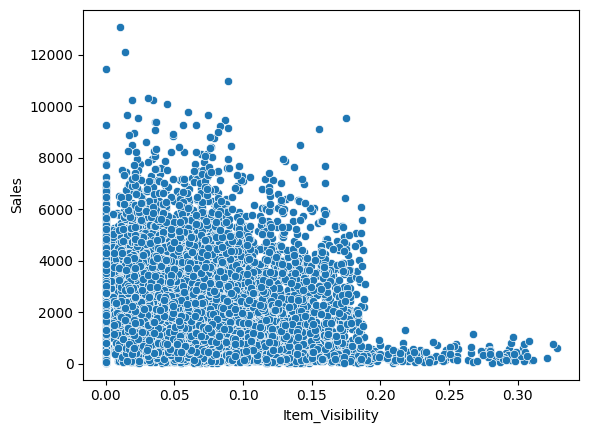

In [560]:
sns.scatterplot(x=sales.Item_Visibility, y=sales.Sales)

That's interesting! Items with less visibility percentage proved to achieve higher sales.

<Axes: xlabel='Sales', ylabel='Outlet_Location_Type'>

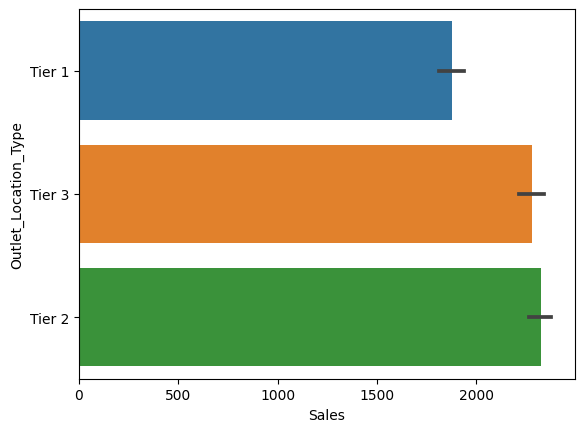

In [561]:
sns.barplot(x=sales.Sales, y=sales.Outlet_Location_Type)

Tier 2 and Tier 3 cities seemed to achieve slightly higher sales than tier 1

<Axes: xlabel='Outlet_Establishment_Year', ylabel='Sales'>

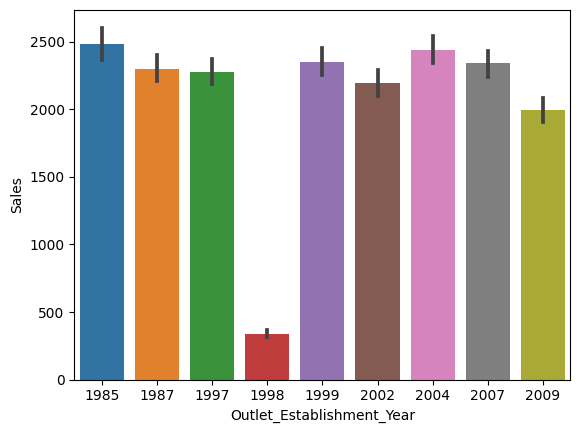

In [562]:
sns.barplot(x=sales.Outlet_Establishment_Year, y=sales.Sales)

<Axes: xlabel='Outlet_Size', ylabel='Sales'>

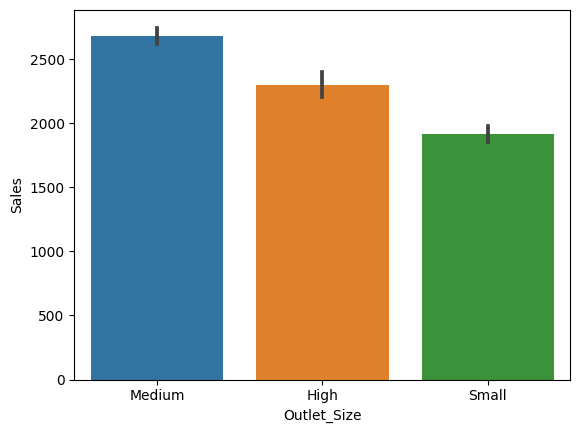

In [563]:
sns.barplot(x=sales.Outlet_Size, y=sales.Sales)

**6) Missing Values**

In [564]:
#replace null values in Item_Weights column by the average weight for each Item_Type

average_weights = sales.groupby('Item_Type')['Item_Weight'].transform('mean')
sales.Item_Weight.fillna(average_weights, inplace = True)

sales.isnull().sum()


Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Sales                           0
dtype: int64

In [565]:
#for Outlet_Size we will use a regression model to fill in the missing values.
sales.Outlet_Size.fillna("Medium", inplace=True)
sales.isnull().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Sales                        0
dtype: int64

**5) Investigating for and treating Outliers**

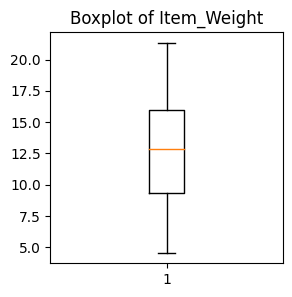

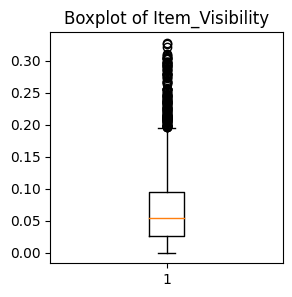

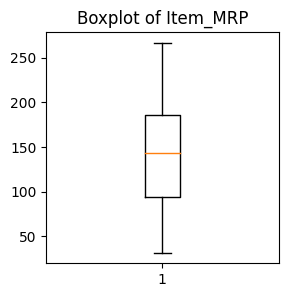

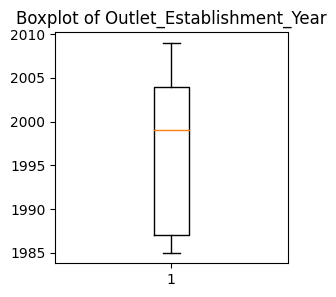

In [566]:
X = sales.drop('Sales', axis=1)
#update cat_cols and num_cols
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
#sales[num_cols].dtype

#plot boxplots
for col in num_cols:
  plt.figure(figsize=(3,3))
  plt.boxplot(X[col])
  plt.title(f"Boxplot of {col}")
  plt.show()

#plt.figure(figsize=(9,3))
#plt.title("Boxplot of numerical variables")
#plt.boxplot(X[num_cols], labels = num_cols)
#plt.show()

It appears that Item_Visibility column has outliers. The rest of our numerical data seems just fine! Now, let's see how we will deal with these outliers.

In [567]:
sales.Item_Visibility.describe()

count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7f855e02f0d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f855e02ca00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f855e02d5a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f855e02cfd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f855e02c6d0>],
 'means': []}

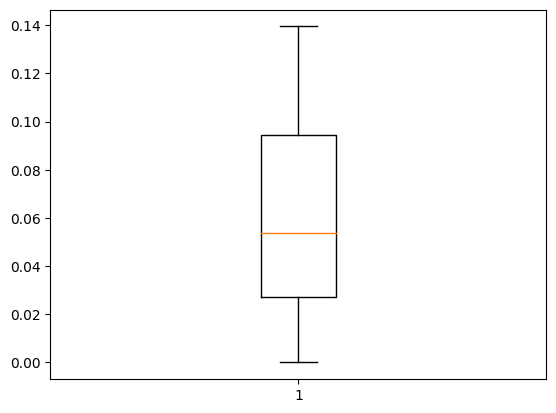

In [568]:
# Apply Winsorization to Item_Visibility
winsorized_column = np.percentile(sales.Item_Visibility, [0, 90])
sales.Item_Visibility = np.clip(sales.Item_Visibility, winsorized_column[0], winsorized_column[1])
plt.boxplot(sales.Item_Visibility)

Great! Now it looks like we got rid of the outliers in our data.

**6) Scaling**


In [569]:
scaler = MinMaxScaler()
sales[num_cols] = scaler.fit_transform(sales[num_cols])
sales[num_cols]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
0,0.282525,0.115023,0.927507,0.583333
1,0.081274,0.138181,0.072068,1.000000
2,0.770765,0.120132,0.468288,0.583333
3,0.871986,0.000000,0.640093,0.541667
4,0.260494,0.000000,0.095805,0.083333
...,...,...,...,...
8518,0.137541,0.407007,0.777729,0.083333
8519,0.227746,0.336757,0.326263,0.708333
8520,0.359929,0.252205,0.228492,0.791667
8521,0.158083,1.000000,0.304939,1.000000


**7) Encoding**

Let's take another look at our categorical columns.

In [570]:
#update cat_cols and num_cols
cat_cols = sales.select_dtypes(include=['object'])
num_cols = sales.select_dtypes(include=['float64', 'int64'])

cat_cols.nunique()

Item_Fat_Content         2
Item_Type               15
Outlet_Identifier       10
Outlet_Size              3
Outlet_Location_Type     3
Outlet_Type              4
dtype: int64

Based on the meanings of our data, we'll use Ordinal Encoding on Item_Fat_Content, Outlet_Size & Outlet_Location_Type.

We'll use One Hot Encoding for the rest of our categorical data.

In [571]:
Ordinal_cols = sales[['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type']].columns
OH = cat_cols.columns.difference(Ordinal_cols)

ordinal_encoder = OrdinalEncoder()
sales[Ordinal_cols] = ordinal_encoder.fit_transform(sales[Ordinal_cols])

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(sales[OH]))
OH_cols.index = sales.index
sales = sales.drop(OH, axis=1)
sales = pd.concat([sales, OH_cols], axis=1)
sales.columns = sales.columns.astype(str)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [572]:
sales.head()


,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Sales,0,1,...,19,20,21,22,23,24,25,26,27,28
0,0.282525,0.0,0.115023,0.927507,0.583333,1.0,0.0,3735.1380,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.081274,1.0,0.138181,0.072068,1.000000,1.0,2.0,443.4228,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.770765,0.0,0.120132,0.468288,0.583333,1.0,0.0,2097.2700,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.871986,1.0,0.000000,0.640093,0.541667,1.0,2.0,732.3800,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.260494,0.0,0.000000,0.095805,0.083333,0.0,2.0,994.7052,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [587]:
#split the data
X = sales.drop('Sales', axis=1)
y = sales.Sales
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=1)

In [588]:
model_1 = LinearRegression()
model_1.fit(train_X, train_y)
predictions = model_1.predict(val_X)
mean_absolute_error(val_y, predictions)

836.0718581931952

In [589]:
model_2 = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state =0,)
model_2.fit(train_X, train_y)
predictions = model_2.predict(val_X)
mean_absolute_error(val_y, predictions)

775.5636994696908

In [607]:
model_3 = XGBRegressor(n_estimators = 1000, learning_rate=0.05, n_jobs = -1, early_stopping_rounds=5, random_state=1)
model_3.fit(train_X, train_y, eval_set = [(val_X, val_y)], verbose = False)
predictions = model_3.predict(val_X)
mean_absolute_error(val_y, predictions)

750.6678469489822